## 1. Классификация предметов одежды (датасет Fashion MNIST)



### 1.1 Решить задачу классификации, не используя сверточные слои. 
* Предложить архитектуру модели для решения задачи
* Посчитать количество параметров модели.
* Обучить модель
* Вывести график функции потерь по эпохам. 
* Используя тестовое множество

  * Продемонстрировать работу модели: вывести несколько изображений, указать над ними правильный класс и класс, предсказанный моделью. 

  * Вывести матрицу ошибок.

  * Вывести значение accuracy на тестовом множестве.
* Сохранить модель

#### Архитектура модели
Эта архитектура нейронной сети включает в себя четыре слоя: 

1. Слой Flatten преобразует входное изображение в одномерный тензор. 

2. Первый линейный слой (nn.Linear) имеет 784 входных нейрона (28x28 изображение, представленное в виде одномерного тензора) и 256 выходных нейронов. 

3. Второй линейный слой имеет 256 входных нейронов и 128 выходных нейронов. 

4. Третий линейный слой имеет 128 входных нейронов и 64 выходных нейрона. 

5. Четвертый и последний линейный слой имеет 64 входных нейрона и 10 выходных нейронов, каждый из которых представляет классы (0-9), которые мы пытаемся классифицировать. 

Каждый линейный слой обрабатывается с использованием функции активации ReLU, которая помогает нейронам обнаруживать нелинейные зависимости между входными и выходными данными. 

В итоге, эта архитектура модели позволяет принимать на вход изображения размером 28х28 и предсказывать их класс (один из 10 возможных классов), используя 3 скрытых слоя и функцию активации ReLU.

In [1]:
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torchvision
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F 
from sklearn.metrics import f1_score, accuracy_score
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

Epoch 1/10 - Training loss: 0.581, Test loss: 0.442, Accuracy: 0.833
Epoch 2/10 - Training loss: 0.394, Test loss: 0.371, Accuracy: 0.867
Epoch 3/10 - Training loss: 0.354, Test loss: 0.341, Accuracy: 0.876
Epoch 4/10 - Training loss: 0.322, Test loss: 0.332, Accuracy: 0.880
Epoch 5/10 - Training loss: 0.307, Test loss: 0.341, Accuracy: 0.874
Epoch 6/10 - Training loss: 0.287, Test loss: 0.318, Accuracy: 0.884
Epoch 7/10 - Training loss: 0.274, Test loss: 0.320, Accuracy: 0.883
Epoch 8/10 - Training loss: 0.262, Test loss: 0.326, Accuracy: 0.882
Epoch 9/10 - Training loss: 0.250, Test loss: 0.311, Accuracy: 0.888
Epoch 10/10 - Training loss: 0.239, Test loss: 0.317, Accuracy: 0.889


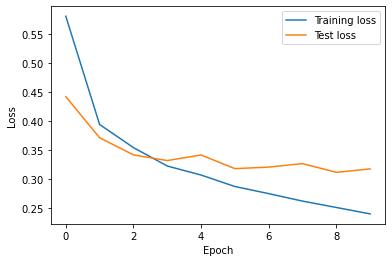

In [2]:

#______________________________________________

class CNN1(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
                nn.Flatten(),
                nn.Linear(784, 256),
                nn.ReLU(),
                nn.Linear(256, 128),
                nn.ReLU(),
                nn.Linear(128, 64),
                nn.ReLU(),
                nn.Linear(64, 10)
            )
        
    def forward(self, x):
        return self.layers(x)

#______________________________________________


model = CNN1()

data_path = './data/fmnist'
# данные в виде картинок 28x28
transform = transforms.Compose([transforms.ToTensor()])
dataset = datasets.FashionMNIST(data_path, train=True, download=True, transform=transform)

val_ratio = 0.2

train_dataset, val_dataset = random_split(
    dataset=dataset, 
    lengths=[int(len(dataset)*(1-val_ratio)), int(len(dataset)*val_ratio)],
)

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 10

train_losses = []
test_losses = []
test_accuracies = []

for epoch in range(epochs):
    
    # Train
    running_loss = 0.0
    model.train()
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    
    # Test
    running_loss = 0.0
    running_accuracy = 0.0
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            predictions = torch.argmax(outputs, dim=1)
            accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
            running_loss += loss.item()
            running_accuracy += accuracy
            

        test_loss = running_loss / len(test_loader)
        test_losses.append(test_loss)
        
        test_accuracy = running_accuracy / len(test_loader)
        test_accuracies.append(test_accuracy)
    
    print(f"Epoch {epoch+1}/{epochs} - Training loss: {train_loss:.3f}, Test loss: {test_loss:.3f}, Accuracy: {test_accuracy:.3f}")
    
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


### 1.2 Решить задачу 1.1, используя сверточную нейронную сеть. 
* Добиться значения accuracy на тестовом множестве не менее 90%
* Визуализировать результаты работы первого сверточного слоя

Сверточный слой (Convolutional layer) - это основной блок сверточной нейронной сети, который применяет свертку к входным данным. Свертка - это математическая операция, которая позволяет извлекать признаки из изображений, звуковых файлов и других типов данных. 

В сверточном слое используется набор фильтров, которые скользят (свертываются) по входным данным и вычисляют операцию свертки. Каждый фильтр обнаруживает определенные признаки во входных данных, такие как границы, текстуры, формы и т.д. В результате свертки получается карта признаков, которая затем подается на следующий слой.

Сверточные слои позволяют нейронной сети автоматически извлекать признаки из входных данных без необходимости задавать их явно. Они также помогают сократить количество параметров в сети, что упрощает ее обучение и ускоряет процесс распознавания. Сверточные сети широко используются для обработки изображений, видео, аудио и других типов данных, где важна локальная структура.


`self.conv1` является первым сверточным слоем и принимает на вход изображения с 1 каналом (черно-белые изображения), поэтому мы устанавливаем `in_channels=1`. Слой имеет 16 фильтров (out_channels=16), что означает, что он будет выдавать 16 карт признаков.

`kernel_size=3` означает, что размер ядра свертки будет 3x3, что позволяет рассматривать каждый пиксель в контексте соседних пикселей. `stride=1` означает, что ядро свертки будет перемещаться на 1 пиксель за раз, чтобы вычислить свертку со всеми пикселями в изображении. `padding=1` означает, что мы дополняем изображение нулями на границах, чтобы избежать уменьшения размера изображения после свертки.

`self.conv2` является вторым сверточным слоем и принимает на вход карты признаков, которые были выданы предыдущим сверточным слоем. В этом случае, `in_channels=16`, потому что первый сверточный слой выдал 16 карт признаков, а `out_channels=32`, что означает, что этот слой будет выдавать 32 карты признаков.

`self.pool` является слоем пуллинга, который выполняет операцию максимального пулинга на картах признаков, чтобы уменьшить размерность изображения. `kernel_size=2` означает, что мы используем окно размером 2x2 для выполнения операции максимального пулинга.

`self.fc1` является полносвязным слоем, который принимает на вход плоский вектор, полученный из карточек признаков, и выдает итоговый результат в виде 10 чисел, соответствующих классам в датасете fashionmnist. Размерность входа для этого слоя равна `32 * 7 * 7`, потому что после применения двух сверточных слоев и слоя пуллинга, размер карт признаков составляет 32x7x7.

Слой пулинга (pooling layer) в сверточных нейронных сетях является одним из основных компонентов, который используется для уменьшения размерности карт признаков, извлеченных из изображений. Он используется после сверточных слоев для сокращения количества параметров модели, уменьшения вычислительной сложности и предотвращения переобучения.

Слой пулинга работает путем разбиения карты признаков на несколько непересекающихся прямоугольных регионов (обычно 2x2 или 3x3), и затем заменяет все значения в каждом регионе на одно значение, которое является максимальным или средним значением в этом регионе. Максимальное пулингирование (max pooling) и среднее пулингирование (average pooling) являются двумя наиболее распространенными типами пулинга.

В результате применения слоя пулинга, размер карт признаков уменьшается в два раза (если используется пулинг размера 2x2), что позволяет уменьшить количество параметров модели и ускорить вычисления. Одновременно это может помочь в избежании переобучения модели, поскольку слой пулинга удаляет избыточную информацию из карт признаков и фокусируется только на наиболее важных признаках.

В сверточных нейронных сетях, слои пулинга обычно применяются после каждого сверточного слоя или нескольких сверточных слоев подряд, для того чтобы уменьшить размерность карт признаков. Они также позволяют сети получать инвариантность к небольшим трансляциям объектов в изображении, что повышает устойчивость к шуму и повышает точность классификации.

Кроме того, слои пулинга не имеют параметров, которые нужно обучать, поэтому они не увеличивают количество параметров в модели и не увеличивают вычислительную сложность.

Stride (шаг) определяет, на сколько пикселей (или элементов в других типах данных) будет сдвигаться фильтр при свертке. Если Stride больше единицы, то фильтр будет перескакивать через несколько пикселей, что уменьшает размер выходных данных. Уменьшение размера может быть полезно, например, для ускорения обучения или для сокращения количества параметров в сети.

Padding (заполнение) - это добавление нулей вокруг границ входных данных перед применением свертки. Заполнение позволяет сохранить размер выходных данных после свертки и уменьшить искажение краевых пикселей. Без заполнения свертка может привести к сокращению размера выходных данных и искажению признаков в углах изображения.

#### Архитектура сети

1. Conv2d layer с 1 входным каналом, 16 выходными каналами, ядром размером 3x3, шагом 1 и заполнением 1.
2. BatchNorm2d layer для нормализации выхода первого Conv2d слоя.
3. Conv2d layer с 16 входными каналами, 32 выходными каналами, ядром размером 3x3, шагом 1 и заполнением 1.
4. BatchNorm2d layer для нормализации выхода второго Conv2d слоя.
5. MaxPool2d слой с ядром размером 2x2 для уменьшения размерности изображения вдвое.
6. Conv2d layer с 32 входными каналами, 64 выходными каналами, ядром размером 3x3, шагом 1 и заполнением 1.
7. BatchNorm2d layer для нормализации выхода третьего Conv2d слоя.
8. MaxPool2d слой с ядром размером 2x2 для уменьшения размерности изображения вдвое.
9. Полносвязный слой (Linear) с 32*7*7 входными нейронами и 10 выходными нейронами.

In [72]:
class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 16, kernel_size=(3,3), stride=1, padding=1),
            nn.BatchNorm2d(16))
 
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(16, 32, kernel_size=(3,3), stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.MaxPool2d((2, 2)))
    
        self.layer3 = torch.nn.Sequential(
            nn.Conv2d(32, 64, (3,3), stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.MaxPool2d((2, 2)))
 
 

        
        self.fc1 = torch.nn.Linear(3136, 10, bias=True)
        

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)   # Flatten them for FC
        out = self.fc1(out)
        return out


#instantiate CNN model
model = CNN()
model

CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=3136, out_features=10, bias=True)
)

In [73]:
learning_rate = 0.001
criterion = torch.nn.CrossEntropyLoss()    # Softmax is internally computed.
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

In [74]:
from torch.autograd import Variable
mnist_train = dsets.MNIST(root='MNIST_data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

mnist_test = dsets.MNIST(root='MNIST_data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

# dataset loader
data_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                          batch_size=batch_size,
                                          shuffle=True)



print('Training the Deep Learning network ...')
train_cost = []
train_accu = []

training_epochs = 10
total_batch = len(mnist_train) // batch_size

print('Size of the training dataset is {}'.format(mnist_train.data.size()))
print('Size of the testing dataset'.format(mnist_test.data.size()))
print('Batch size is : {}'.format(batch_size))
print('Total number of batches is : {0:2.0f}'.format(total_batch))
print('\nTotal number of epochs is : {0:2.0f}'.format(training_epochs))

for epoch in range(training_epochs):
    avg_cost = 0
    for i, (batch_X, batch_Y) in enumerate(data_loader):
        X = Variable(batch_X)    # image is already size of (28x28), no reshape
        Y = Variable(batch_Y)    # label is not one-hot encoded

        optimizer.zero_grad() # <= initialization of the gradients
        
        # forward propagation
        hypothesis = model(X)
        cost = criterion(hypothesis, Y) # <= compute the loss function
        
        # Backward propagation
        cost.backward() # <= compute the gradient of the loss/cost function     
        optimizer.step() # <= Update the gradients
             
        # Print some performance to monitor the training
        prediction = hypothesis.data.max(dim=1)[1]
        train_accu.append(((prediction.data == Y.data).float().mean()).item())
        train_cost.append(cost.item())   
        if i % 200 == 0:
            print("Epoch= {},\t batch = {},\t cost = {:2.4f},\t accuracy = {}".format(epoch+1, i, train_cost[-1], train_accu[-1]))
       
        avg_cost += cost.data / total_batch

    print("[Epoch: {:>4}], averaged cost = {:>.9}".format(epoch + 1, avg_cost.item()))


print('Learning Finished!')



Training the Deep Learning network ...
Size of the training dataset is torch.Size([60000, 28, 28])
Size of the testing dataset
Batch size is : 64
Total number of batches is : 937

Total number of epochs is : 10
Epoch= 1,	 batch = 0,	 cost = 2.4105,	 accuracy = 0.0625
Epoch= 1,	 batch = 200,	 cost = 0.0750,	 accuracy = 0.953125
Epoch= 1,	 batch = 400,	 cost = 0.1013,	 accuracy = 0.953125
Epoch= 1,	 batch = 600,	 cost = 0.0346,	 accuracy = 0.984375
Epoch= 1,	 batch = 800,	 cost = 0.0603,	 accuracy = 0.96875
[Epoch:    1], averaged cost = 0.127663195
Epoch= 2,	 batch = 0,	 cost = 0.0580,	 accuracy = 0.96875
Epoch= 2,	 batch = 200,	 cost = 0.0419,	 accuracy = 0.984375
Epoch= 2,	 batch = 400,	 cost = 0.0032,	 accuracy = 1.0
Epoch= 2,	 batch = 600,	 cost = 0.0163,	 accuracy = 1.0
Epoch= 2,	 batch = 800,	 cost = 0.0134,	 accuracy = 1.0
[Epoch:    2], averaged cost = 0.060675323
Epoch= 3,	 batch = 0,	 cost = 0.0323,	 accuracy = 0.984375
Epoch= 3,	 batch = 200,	 cost = 0.1218,	 accuracy = 0.968

In [75]:
# Test model and check accuracy
model.eval()    # set the model to evaluation mode (dropout=False)

X_test = Variable(mnist_test.data.view(len(mnist_test), 1, 28, 28).float())
Y_test = Variable(mnist_test.targets)

prediction = model(X_test)

# Compute accuracy
correct_prediction = (torch.max(prediction.data, dim=1)[1] == Y_test.data)
accuracy = correct_prediction.float().mean().item()
print('\nAccuracy: {:2.2f} %'.format(accuracy*100))


Accuracy: 87.20 %


##  2. Классификация изображений (датасет CIFAR 10) 


### 2.1 Решить задачу классификации, не используя сверточные слои. 

* Нормализовать данные (если необходимо)
* Предложить архитектуру модели для решения задачи
* Посчитать количество параметров модели.
* Обучить модель
* Вывести график функции потерь по эпохам. 
* Используя тестовое множество

  * Продемонстрировать работу модели: вывести несколько изображений, указать над ними правильный класс и класс, предсказанный моделью. 

  * Вывести матрицу ошибок.

  * Вывести значение accuracy на тестовом множестве.
* Сохранить модель

Files already downloaded and verified
Epoch 1/10 - Training loss: 1.918, Test loss: 1.785, Accuracy: 0.358
Epoch 2/10 - Training loss: 1.716, Test loss: 1.707, Accuracy: 0.386
Epoch 3/10 - Training loss: 1.639, Test loss: 1.616, Accuracy: 0.427
Epoch 4/10 - Training loss: 1.576, Test loss: 1.617, Accuracy: 0.419
Epoch 5/10 - Training loss: 1.530, Test loss: 1.618, Accuracy: 0.417
Epoch 6/10 - Training loss: 1.491, Test loss: 1.500, Accuracy: 0.460
Epoch 7/10 - Training loss: 1.455, Test loss: 1.530, Accuracy: 0.455
Epoch 8/10 - Training loss: 1.436, Test loss: 1.476, Accuracy: 0.472
Epoch 9/10 - Training loss: 1.406, Test loss: 1.530, Accuracy: 0.456
Epoch 10/10 - Training loss: 1.383, Test loss: 1.465, Accuracy: 0.478


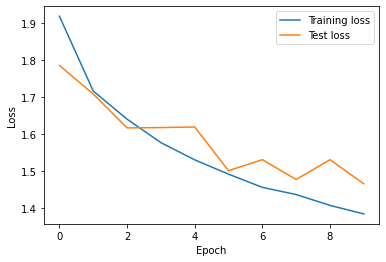

In [6]:
class CNN1(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
                nn.Flatten(),
                nn.Linear(3072, 256),
                nn.ReLU(),
                nn.Linear(256, 128),
                nn.ReLU(),
                nn.Linear(128, 64),
                nn.ReLU(),
                nn.Linear(64, 10)
            )
        
    def forward(self, x):
        return self.layers(x)

#______________________________________________


model = CNN1()


transform = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()])
dataset = datasets.CIFAR10('data_cifar10', train=True, download=True, transform=transform)

val_ratio = 0.2

train_dataset, val_dataset = random_split(
    dataset=dataset, 
    lengths=[int(len(dataset)*(1-val_ratio)), int(len(dataset)*val_ratio)],
)

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs =10

train_losses = []
test_losses = []
test_accuracies = []

for epoch in range(epochs):
    
    # Train
    running_loss = 0.0
    model.train()
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    
    # Test
    running_loss = 0.0
    running_accuracy = 0.0
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            predictions = torch.argmax(outputs, dim=1)
            accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
            running_loss += loss.item()
            running_accuracy += accuracy
            

        test_loss = running_loss / len(test_loader)
        test_losses.append(test_loss)
        
        test_accuracy = running_accuracy / len(test_loader)
        test_accuracies.append(test_accuracy)
    
    print(f"Epoch {epoch+1}/{epochs} - Training loss: {train_loss:.3f}, Test loss: {test_loss:.3f}, Accuracy: {test_accuracy:.3f}")
    
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


<ipython-input-10-d81d3f14c968>:16: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])


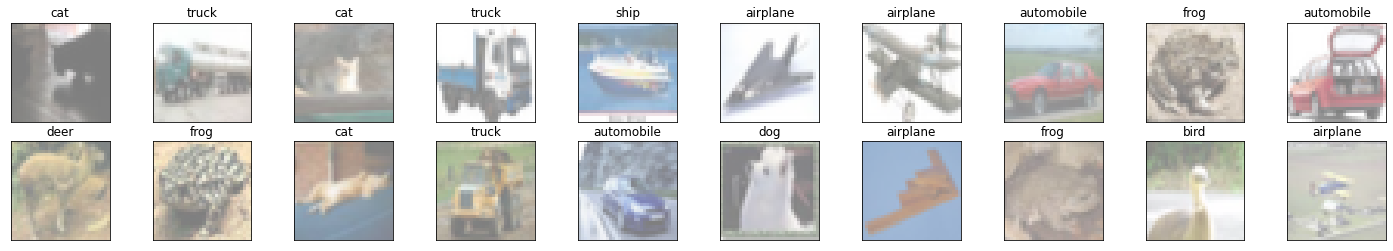

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']
def imshow(img):
    img = img / 2 + 0.5  
    plt.imshow(np.transpose(img, (1, 2, 0)))  

dataiter = iter(test_loader)
images, labels = next(dataiter)
images = images.numpy() 

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

### 2.2 Решить задачу 2.1, используя сверточную нейронную сеть. 
* Добиться значения accuracy на тестовом множестве не менее 70%.
* Визуализировать результаты работы первого сверточного слоя

Мы умножаем на 8 два раза, потому что на этом этапе мы преобразуем выход сверточных слоев в вектор перед передачей его в полносвязный слой. Размер выхода сверточных слоев в нашей модели составляет 64x8x8, где 64 - это количество фильтров, 8 - это высота и ширина выхода сверточных слоев. 

Первое умножение на 8 происходит в строке `x = self.maxpool(x)`, где мы уменьшаем высоту и ширину выхода сверточных слоев в 2 раза с помощью операции max pooling. В результате, высота и ширина выхода становятся равными 8.

Второе умножение на 8 происходит в строке `x = x.view(-1, 64*8*8)`, где мы преобразуем выход сверточных слоев в вектор. Для этого мы умножаем количество фильтров (64) на высоту (8) и ширину (8) выхода сверточных слоев.

Таким образом, мы получаем одномерный вектор длиной 4096 (64*8*8), который передаётся в полносвязный слой размерности 512.

Высоту и ширину сверточного слоя определяют конфигурация сверточного слоя и размер входного изображения. 

Например, в модели из предыдущего ответа мы использовали два сверточных слоя с ядром размера 3x3 и с одинаковым заполнением (padding) равным 1. Это означает, что каждый пиксель входного изображения будет окружен пикселями из заполнения, чтобы размер выхода сверточного слоя был таким же, как и размер входа. 

Если входное изображение имеет размер 32x32 (32 пикселя по высоте и 32 пикселя по ширине), то после первого сверточного слоя размер выхода будет составлять 32x32 пикселя. Затем мы применяем операцию max pooling с ядром размера 2x2 и шагом (stride) 2, чтобы уменьшить размер выхода в 2 раза. Это дает нам выход размером 16x16 пикселей. После второго сверточного слоя размер выхода также составляет 16x16 пикселей.

Затем мы преобразуем выход сверточных слоев в вектор и передаем его в полносвязный слой. Для этого мы умножаем количество фильтров (64) на высоту (8) и ширину (8) выхода сверточных слоев, который в данном случае равен 16x16 (8 = 16/2/2).

Высота и ширина сверточного слоя определяются размером входного изображения, размером ядра свертки и параметрами padding и stride. 

Например, в случае сверточного слоя с ядром размером 3x3 и padding=1, для входного изображения размером 32x32 высота и ширина сверточного слоя будут равны 32. Если добавить stride=2, то высота и ширина сверточного слоя будут уменьшены в два раза и станут равными 16.

При последующих сверточных слоях высота и ширина могут изменяться в зависимости от размера ядра, padding, stride и количества фильтров в слое. Например, при увеличении количества фильтров высота и ширина могут уменьшаться, так как размерность выходного тензора увеличивается за счет большего количества фильтров.

In [38]:
class CNN(torch.nn.Module):

#     def __init__(self):
#         super(CNN, self).__init__()
#         self.layer1 = torch.nn.Sequential(
#             torch.nn.Conv2d(3, 16, kernel_size=(3,3), stride=1, padding=1),
#             nn.BatchNorm2d(16))
 
#         self.layer2 = torch.nn.Sequential(
#             torch.nn.Conv2d(16, 32, kernel_size=(3,3), stride=1, padding=1),
#             nn.BatchNorm2d(32),
#             nn.MaxPool2d((2, 2)))
    
#         self.layer3 = torch.nn.Sequential(
#             nn.Conv2d(32, 64, (3,3), stride=1, padding=1),
#             nn.BatchNorm2d(64),
#             nn.MaxPool2d((2, 2)))

        
#         self.fc1 = torch.nn.Linear(4096, 10, bias=True)
        

#     def forward(self, x):
#         out = self.layer1(x)
#         out = self.layer2(out)
#         out = self.layer3(out)
#         out = out.view(out.size(0), -1)   # Flatten them for FC
#         out = self.fc1(out)
#         return out

    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = self.pool(nn.functional.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = self.dropout(nn.functional.relu(self.fc1(x)))
        x = self.fc2(x)
        return x


#instantiate CNN model
model = CNN()
model

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [39]:
learning_rate = 0.001
criterion = torch.nn.CrossEntropyLoss()    # Softmax is internally computed.
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

In [40]:
from torch.autograd import Variable
cifar_train = datasets.CIFAR10(root='CIFAR10_data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

cifar_test = datasets.CIFAR10(root='CIFAR10_data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)
batch_size = 128
# dataset loader
data_loader = torch.utils.data.DataLoader(dataset=cifar_train,
                                          batch_size=batch_size,
                                          shuffle=True)



print('Training the Deep Learning network ...')
train_cost = []
train_accu = []

training_epochs = 10
total_batch = len(cifar_train) // batch_size

print('Size of the training dataset is {}'.format(cifar_train.data.shape))
print('Size of the testing dataset'.format(cifar_test.data.shape))
print('Batch size is : {}'.format(batch_size))
print('Total number of batches is : {0:2.0f}'.format(total_batch))
print('\nTotal number of epochs is : {0:2.0f}'.format(training_epochs))

for epoch in range(training_epochs):
    avg_cost = 0
    for i, (batch_X, batch_Y) in enumerate(data_loader):
        X = Variable(batch_X)    # image is already size of (28x28), no reshape
        Y = Variable(batch_Y)    # label is not one-hot encoded

        optimizer.zero_grad() # <= initialization of the gradients
        
        # forward propagation
        hypothesis = model(X)
        cost = criterion(hypothesis, Y) # <= compute the loss function
        
        # Backward propagation
        cost.backward() # <= compute the gradient of the loss/cost function     
        optimizer.step() # <= Update the gradients
             
        # Print some performance to monitor the training
        prediction = hypothesis.data.max(dim=1)[1]
        train_accu.append(((prediction.data == Y.data).float().mean()).item())
        train_cost.append(cost.item())   
        if i % 200 == 0:
            print("Epoch= {},\t batch = {},\t cost = {:2.4f},\t accuracy = {}".format(epoch+1, i, train_cost[-1], train_accu[-1]))
       
        avg_cost += cost.data / total_batch

    print("[Epoch: {:>4}], averaged cost = {:>.9}".format(epoch + 1, avg_cost.item()))


print('Learning Finished!')



Files already downloaded and verified
Files already downloaded and verified
Training the Deep Learning network ...
Size of the training dataset is (50000, 32, 32, 3)
Size of the testing dataset
Batch size is : 128
Total number of batches is : 390

Total number of epochs is : 10
Epoch= 1,	 batch = 0,	 cost = 2.3019,	 accuracy = 0.0625
Epoch= 1,	 batch = 200,	 cost = 1.5441,	 accuracy = 0.390625
[Epoch:    1], averaged cost = 1.66160393
Epoch= 2,	 batch = 0,	 cost = 1.3217,	 accuracy = 0.5390625
Epoch= 2,	 batch = 200,	 cost = 1.1918,	 accuracy = 0.625
[Epoch:    2], averaged cost = 1.26031792
Epoch= 3,	 batch = 0,	 cost = 1.0533,	 accuracy = 0.6328125
Epoch= 3,	 batch = 200,	 cost = 1.1066,	 accuracy = 0.625
[Epoch:    3], averaged cost = 1.080158
Epoch= 4,	 batch = 0,	 cost = 0.9379,	 accuracy = 0.6171875
Epoch= 4,	 batch = 200,	 cost = 1.0289,	 accuracy = 0.6484375
[Epoch:    4], averaged cost = 0.953641236
Epoch= 5,	 batch = 0,	 cost = 0.8440,	 accuracy = 0.671875
Epoch= 5,	 batch = 

In [41]:
# Load test data
test_loader = torch.utils.data.DataLoader(dataset=cifar_test,
                                          batch_size=batch_size,
                                          shuffle=False)

# Set the model to evaluation mode
model.eval()

# Iterate over the test data and make predictions
correct = 0
total = 0
for images, labels in test_loader:
    images = Variable(images)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

# Calculate and print accuracy
accuracy = 100 * correct / total
print('Accuracy of the network on the 10000 test images: %d %%' % accuracy)


Accuracy of the network on the 10000 test images: 75 %


## 3. Загрузка изображений из внешних источников

### 3.1 Решить задачу классификации обезьян (датасет [monkey.zip](https://disk.yandex.ru/d/OxYgY4S7aR6ulQ)).
* Загрузить архив с данными на диск
* Создать датасет на основе файлов при помощи `torchvision.datasets.ImageFolder`
* Преобразовать изображения к тензорами одного размера (например, 400х400). Потестировать другие преобразования из `torchvision.transforms`
* Предложить архитектуру модели для решения задачи. Обучить модель.
* Используя тестовое множество

  * Продемонстрировать работу модели: вывести несколько изображений, указать над ними правильный класс и класс, предсказанный моделью. 

  * Вывести матрицу ошибок.

  * Вывести значение accuracy на тестовом множестве.
  * Добиться значения accuracy на тестовом множестве не менее 60%

In [44]:
transform = transforms.Compose([transforms.Resize((400, 400)), transforms.ToTensor()])
dataset = datasets.ImageFolder('C:\\Users\\-\\Downloads\\monkeys\\training\\training', transform=transform)

In [46]:
dataset

Dataset ImageFolder
    Number of datapoints: 1097
    Root location: C:\Users\-\Downloads\monkeys\training\training
    StandardTransform
Transform: Compose(
               Resize(size=(400, 400), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )

Epoch 1/10 - Training loss: 11.046, Test loss: 4.528, Accuracy: 0.151
Epoch 2/10 - Training loss: 2.918, Test loss: 2.636, Accuracy: 0.173
Epoch 3/10 - Training loss: 2.234, Test loss: 2.260, Accuracy: 0.259
Epoch 4/10 - Training loss: 1.797, Test loss: 2.058, Accuracy: 0.301
Epoch 5/10 - Training loss: 1.720, Test loss: 2.270, Accuracy: 0.291
Epoch 6/10 - Training loss: 1.586, Test loss: 1.856, Accuracy: 0.346
Epoch 7/10 - Training loss: 1.345, Test loss: 2.049, Accuracy: 0.286
Epoch 8/10 - Training loss: 1.351, Test loss: 1.958, Accuracy: 0.298
Epoch 9/10 - Training loss: 1.206, Test loss: 2.264, Accuracy: 0.292
Epoch 10/10 - Training loss: 1.134, Test loss: 1.879, Accuracy: 0.366


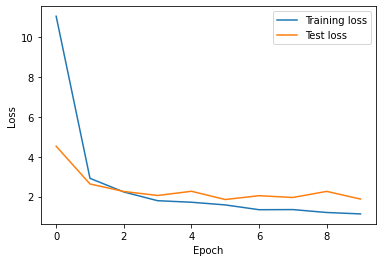

In [54]:
class CNN1(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
                nn.Flatten(),
                nn.Linear(480000, 256),
                nn.ReLU(),
                nn.Linear(256, 128),
                nn.ReLU(),
                nn.Linear(128, 64),
                nn.ReLU(),
                nn.Linear(64, 10)
            )
        
    def forward(self, x):
        return self.layers(x)

#______________________________________________


model = CNN1()





# Разбиваем датасет на тренировочную и тестовую выборки
val_ratio = 0.2
val_size = int(val_ratio * len(dataset))
train_size = len(dataset) - val_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Объявляем загрузчики данных для тренировочной и тестовой выборок
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)



device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs =10

train_losses = []
test_losses = []
test_accuracies = []

for epoch in range(epochs):
    
    # Train
    running_loss = 0.0
    model.train()
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    
    # Test
    # ...

    running_loss = 0.0
    running_accuracy = 0.0
    model.eval()
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            predictions = torch.argmax(outputs, dim=1)
            accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
            running_loss += loss.item()
            running_accuracy += accuracy


    test_loss = running_loss / len(val_loader)
    test_losses.append(test_loss)

    test_accuracy = running_accuracy / len(val_loader)
    test_accuracies.append(test_accuracy)

# ...

    
    print(f"Epoch {epoch+1}/{epochs} - Training loss: {train_loss:.3f}, Test loss: {test_loss:.3f}, Accuracy: {test_accuracy:.3f}")
    
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


### 3.2 Решить задачу классификации собак и кошек (датасет [cats_dogs.zip](https://disk.yandex.ru/d/wQtt5O1JF9ctnA)).
* Загрузить архив с данными на диск
* Создать датасет на основе файлов при помощи `torchvision.datasets.ImageFolder`
* Преобразовать изображения к тензорами одного размера (например, 400х400). Потестировать другие преобразования из `torchvision.transforms`
* Предложить архитектуру модели для решения задачи. Обучить модель.
* Используя тестовое множество

  * Продемонстрировать работу модели: вывести несколько изображений, указать над ними правильный класс и класс, предсказанный моделью. 

  * Вывести матрицу ошибок.

  * Вывести значение accuracy на тестовом множестве.
  * Добиться значения accuracy на тестовом множестве не менее 80%

In [6]:
transform = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()])
dataset = datasets.ImageFolder('C:\\Users\\-\\Downloads\\cats_dogs\\cats_dogs\\train', transform=transform)

Epoch 1/10 - Training loss: 0.699, Test loss: 0.668, Accuracy: 0.596
Epoch 2/10 - Training loss: 0.662, Test loss: 0.646, Accuracy: 0.630
Epoch 3/10 - Training loss: 0.652, Test loss: 0.663, Accuracy: 0.598
Epoch 4/10 - Training loss: 0.646, Test loss: 0.641, Accuracy: 0.634
Epoch 5/10 - Training loss: 0.636, Test loss: 0.635, Accuracy: 0.635
Epoch 6/10 - Training loss: 0.632, Test loss: 0.644, Accuracy: 0.618
Epoch 7/10 - Training loss: 0.628, Test loss: 0.649, Accuracy: 0.604
Epoch 8/10 - Training loss: 0.623, Test loss: 0.632, Accuracy: 0.646
Epoch 9/10 - Training loss: 0.618, Test loss: 0.617, Accuracy: 0.651
Epoch 10/10 - Training loss: 0.613, Test loss: 0.634, Accuracy: 0.640


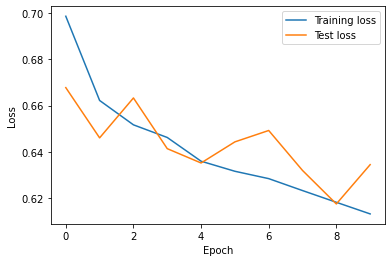

In [8]:
class CNN1(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
                nn.Flatten(),
                nn.Linear(3072, 256),
                nn.ReLU(),
                nn.Linear(256, 128),
                nn.ReLU(),
                nn.Linear(128, 64),
                nn.ReLU(),
                nn.Linear(64, 10)
            )
        
    def forward(self, x):
        return self.layers(x)

#______________________________________________


model = CNN1()





# Разбиваем датасет на тренировочную и тестовую выборки
val_ratio = 0.2
val_size = int(val_ratio * len(dataset))
train_size = len(dataset) - val_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Объявляем загрузчики данных для тренировочной и тестовой выборок
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)



device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 10

train_losses = []
test_losses = []
test_accuracies = []

for epoch in range(epochs):
    
    # Train
    running_loss = 0.0
    model.train()
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    
    # Test
    # ...

    running_loss = 0.0
    running_accuracy = 0.0
    model.eval()
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            predictions = torch.argmax(outputs, dim=1)
            accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
            running_loss += loss.item()
            running_accuracy += accuracy


    test_loss = running_loss / len(val_loader)
    test_losses.append(test_loss)

    test_accuracy = running_accuracy / len(val_loader)
    test_accuracies.append(test_accuracy)

# ...

    
    print(f"Epoch {epoch+1}/{epochs} - Training loss: {train_loss:.3f}, Test loss: {test_loss:.3f}, Accuracy: {test_accuracy:.3f}")
    
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


# 4. Transfer Learning

### 4.1 Решить задачу 3.1, воспользовавшись предобученной моделью VGG16
* Загрузить данные для обучения
* Преобразования: размер 224x224, нормализация с параметрами `mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)`
* Заменить последний полносвязный слой модели в соответствии с задачей
* Дообучить модель (не замораживать веса). Вычислить значение accuracy на тестовом множестве
* Дообучить модель (заморозить все веса, кроме последнего блока слоев (`classifier`)). 
* Вычислить значение accuracy на тестовом множестве.


In [2]:
import torch
import torchvision
from torchvision import transforms

# загрузка данных
train_data = torchvision.datasets.ImageFolder(root='C:\\Users\\-\\Downloads\\monkeys\\training\\training', transform=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]))

test_data = torchvision.datasets.ImageFolder(root='C:\\Users\\-\\Downloads\\monkeys\\validation\\validation', transform=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]))

# разделение данных на батчи
batch_size = 32

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)


In [10]:
import torch.nn as nn
import torchvision.models as models

# загрузка предобученной модели VGG16
model = models.vgg16(pretrained=True)



# замена последнего полносвязного слоя
n_inputs = model.classifier[-1].in_features
last_layer = nn.Linear(n_inputs, 10)
model.classifier[-1] = last_layer

# вывод модели
print(model)
    

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\-/.cache\torch\hub\checkpoints\vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Epoch 1/10 - Training loss: 2.110, Test loss: 2.009, Accuracy: 0.302
Epoch 2/10 - Training loss: 1.997, Test loss: 2.066, Accuracy: 0.194
Epoch 3/10 - Training loss: 1.935, Test loss: 2.119, Accuracy: 0.233
Epoch 4/10 - Training loss: 1.969, Test loss: 1.966, Accuracy: 0.253
Epoch 5/10 - Training loss: 1.896, Test loss: 1.958, Accuracy: 0.257
Epoch 6/10 - Training loss: 1.886, Test loss: 1.999, Accuracy: 0.247
Epoch 7/10 - Training loss: 1.863, Test loss: 1.944, Accuracy: 0.257
Epoch 8/10 - Training loss: 1.866, Test loss: 1.931, Accuracy: 0.330
Epoch 9/10 - Training loss: 1.772, Test loss: 2.018, Accuracy: 0.271
Epoch 10/10 - Training loss: 1.788, Test loss: 2.411, Accuracy: 0.160


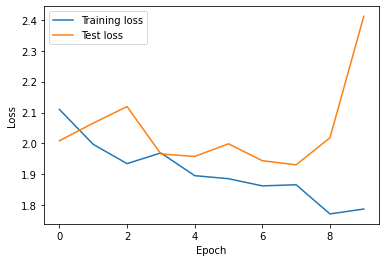

In [14]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 10

train_losses = []
test_losses = []
test_accuracies = []

for epoch in range(epochs):
    
    # Train
    running_loss = 0.0
    model.train()
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    
    # Test
    # ...

    running_loss = 0.0
    running_accuracy = 0.0
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            predictions = torch.argmax(outputs, dim=1)
            accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
            running_loss += loss.item()
            running_accuracy += accuracy


    test_loss = running_loss / len(test_loader)
    test_losses.append(test_loss)

    test_accuracy = running_accuracy / len(test_loader)
    test_accuracies.append(test_accuracy)

    
    print(f"Epoch {epoch+1}/{epochs} - Training loss: {train_loss:.3f}, Test loss: {test_loss:.3f}, Accuracy: {test_accuracy:.3f}")
    
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [15]:
# заморозка весов, кроме последнего блока слоев
for param in model.features.parameters():
    param.requires_grad = False

for param in model.classifier[0:4].parameters():
    param.requires_grad = False

# вывод модели
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Epoch 1/10 - Training loss: 2.056, Test loss: 2.061, Accuracy: 0.222
Epoch 2/10 - Training loss: 2.022, Test loss: 2.044, Accuracy: 0.194
Epoch 3/10 - Training loss: 2.006, Test loss: 2.064, Accuracy: 0.240
Epoch 4/10 - Training loss: 2.002, Test loss: 2.051, Accuracy: 0.264
Epoch 5/10 - Training loss: 2.008, Test loss: 2.039, Accuracy: 0.201
Epoch 6/10 - Training loss: 1.999, Test loss: 2.039, Accuracy: 0.243
Epoch 7/10 - Training loss: 1.991, Test loss: 2.021, Accuracy: 0.240
Epoch 8/10 - Training loss: 1.999, Test loss: 2.045, Accuracy: 0.229
Epoch 9/10 - Training loss: 1.997, Test loss: 2.037, Accuracy: 0.267
Epoch 10/10 - Training loss: 1.993, Test loss: 2.036, Accuracy: 0.250


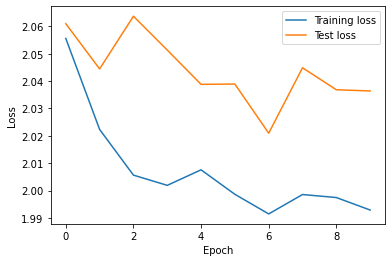

In [17]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 10

train_losses = []
test_losses = []
test_accuracies = []

for epoch in range(epochs):
    
    # Train
    running_loss = 0.0
    model.train()
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    
    # Test
    # ...

    running_loss = 0.0
    running_accuracy = 0.0
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            predictions = torch.argmax(outputs, dim=1)
            accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
            running_loss += loss.item()
            running_accuracy += accuracy


    test_loss = running_loss / len(test_loader)
    test_losses.append(test_loss)

    test_accuracy = running_accuracy / len(test_loader)
    test_accuracies.append(test_accuracy)

    
    print(f"Epoch {epoch+1}/{epochs} - Training loss: {train_loss:.3f}, Test loss: {test_loss:.3f}, Accuracy: {test_accuracy:.3f}")
    
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 4.2 Решить задачу 3.2, воспользовавшись подходящей предобученной моделью
* Не использовать VGG16 (вместо нее можно взять resnet18 или другую)
* Загрузить данные для обучения
* Преобразования: размер 224x224, нормализация с параметрами `mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)`
* Заменить последний полносвязный слой модели в соответствии с задачей
* Дообучить модель. 
* Вычислить значение accuracy на тестовом множестве (добиться значения не меньше 97-98%)

In [18]:
import torch
import torchvision
from torchvision import transforms

# загрузка данных
train_data = torchvision.datasets.ImageFolder(root='C:\\Users\\-\\Downloads\\monkeys\\training\\training', transform=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]))

test_data = torchvision.datasets.ImageFolder(root='C:\\Users\\-\\Downloads\\monkeys\\validation\\validation', transform=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]))

# разделение данных на батчи
batch_size = 32

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)


In [20]:
model = models.resnet18(pretrained=True)

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)


Epoch 1/10 - Training loss: 0.473, Test loss: 2.095, Accuracy: 0.601
Epoch 2/10 - Training loss: 0.255, Test loss: 0.309, Accuracy: 0.892
Epoch 3/10 - Training loss: 0.081, Test loss: 0.244, Accuracy: 0.931
Epoch 4/10 - Training loss: 0.076, Test loss: 0.887, Accuracy: 0.851
Epoch 5/10 - Training loss: 0.132, Test loss: 0.386, Accuracy: 0.851
Epoch 6/10 - Training loss: 0.137, Test loss: 0.473, Accuracy: 0.878
Epoch 7/10 - Training loss: 0.194, Test loss: 1.922, Accuracy: 0.622
Epoch 8/10 - Training loss: 0.101, Test loss: 0.213, Accuracy: 0.941
Epoch 9/10 - Training loss: 0.095, Test loss: 0.584, Accuracy: 0.830
Epoch 10/10 - Training loss: 0.143, Test loss: 1.047, Accuracy: 0.778


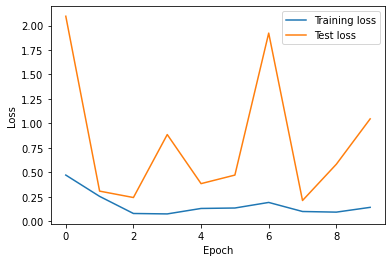

In [22]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 10

train_losses = []
test_losses = []
test_accuracies = []

for epoch in range(epochs):
    
    # Train
    running_loss = 0.0
    model.train()
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    
    # Test
    # ...

    running_loss = 0.0
    running_accuracy = 0.0
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            predictions = torch.argmax(outputs, dim=1)
            accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
            running_loss += loss.item()
            running_accuracy += accuracy


    test_loss = running_loss / len(test_loader)
    test_losses.append(test_loss)

    test_accuracy = running_accuracy / len(test_loader)
    test_accuracies.append(test_accuracy)

    
    print(f"Epoch {epoch+1}/{epochs} - Training loss: {train_loss:.3f}, Test loss: {test_loss:.3f}, Accuracy: {test_accuracy:.3f}")
    
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()